In [1]:
%matplotlib inline


# *origin* and *extent* in `~.Axes.imshow`

:meth:`~.Axes.imshow` allows you to render an image (either a 2D array
which will be color-mapped (based on *norm* and *cmap*) or a 3D RGB(A)
array which will be used as-is) to a rectangular region in data space.
The orientation of the image in the final rendering is controlled by
the *origin* and *extent* kwargs (and attributes on the resulting
`~.AxesImage` instance) and the data limits of the axes.

The *extent* kwarg controls the bounding box in data coordinates that
the image will fill specified as ``(left, right, bottom, top)`` in
**data coordinates**, the *origin* kwarg controls how the image fills
that bounding box, and the orientation in the final rendered image is
also affected by the axes limits.

.. hint:: Most of the code below is used for adding labels and informative
   text to the plots. The described effects of *origin* and *extent* can be
   seen in the plots without the need to follow all code details.

   For a quick understanding, you may want to skip the code details below and
   directly continue with the discussion of the results.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


def index_to_coordinate(index, extent, origin):
    """Return the pixel center of an index."""
    left, right, bottom, top = extent

    hshift = 0.5 * np.sign(right - left)
    left, right = left + hshift, right - hshift
    vshift = 0.5 * np.sign(top - bottom)
    bottom, top = bottom + vshift, top - vshift

    if origin == 'upper':
        bottom, top = top, bottom

    return {
        "[0, 0]": (left, bottom),
        "[M', 0]": (left, top),
        "[0, N']": (right, bottom),
        "[M', N']": (right, top),
    }[index]


def get_index_label_pos(index, extent, origin, inverted_xindex):
    """
    Return the desired position and horizontal alignment of an index label.
    """
    if extent is None:
        extent = lookup_extent(origin)
    left, right, bottom, top = extent
    x, y = index_to_coordinate(index, extent, origin)

    is_x0 = index[-2:] == "0]"
    halign = 'left' if is_x0 ^ inverted_xindex else 'right'
    hshift = 0.5 * np.sign(left - right)
    x += hshift * (1 if is_x0 else -1)
    return x, y, halign


def get_color(index, data, cmap):
    """Return the data color of an index."""
    val = {
        "[0, 0]": data[0, 0],
        "[0, N']": data[0, -1],
        "[M', 0]": data[-1, 0],
        "[M', N']": data[-1, -1],
    }[index]
    return cmap(val / data.max())


def lookup_extent(origin):
    """Return extent for label positioning when not given explicitly."""
    if origin == 'lower':
        return (-0.5, 6.5, -0.5, 5.5)
    else:
        return (-0.5, 6.5, 5.5, -0.5)


def set_extent_None_text(ax):
    ax.text(3, 2.5, 'equals\nextent=None', size='large',
            ha='center', va='center', color='w')


def plot_imshow_with_labels(ax, data, extent, origin, xlim, ylim):
    """Actually run ``imshow()`` and add extent and index labels."""
    im = ax.imshow(data, origin=origin, extent=extent)

    # extent labels (left, right, bottom, top)
    left, right, bottom, top = im.get_extent()
    if xlim is None or top > bottom:
        upper_string, lower_string = 'top', 'bottom'
    else:
        upper_string, lower_string = 'bottom', 'top'
    if ylim is None or left < right:
        port_string, starboard_string = 'left', 'right'
        inverted_xindex = False
    else:
        port_string, starboard_string = 'right', 'left'
        inverted_xindex = True
    bbox_kwargs = {'fc': 'w', 'alpha': .75, 'boxstyle': "round4"}
    ann_kwargs = {'xycoords': 'axes fraction',
                  'textcoords': 'offset points',
                  'bbox': bbox_kwargs}
    ax.annotate(upper_string, xy=(.5, 1), xytext=(0, -1),
                ha='center', va='top', **ann_kwargs)
    ax.annotate(lower_string, xy=(.5, 0), xytext=(0, 1),
                ha='center', va='bottom', **ann_kwargs)
    ax.annotate(port_string, xy=(0, .5), xytext=(1, 0),
                ha='left', va='center', rotation=90,
                **ann_kwargs)
    ax.annotate(starboard_string, xy=(1, .5), xytext=(-1, 0),
                ha='right', va='center', rotation=-90,
                **ann_kwargs)
    ax.set_title('origin: {origin}'.format(origin=origin))

    # index labels
    for index in ["[0, 0]", "[0, N']", "[M', 0]", "[M', N']"]:
        tx, ty, halign = get_index_label_pos(index, extent, origin,
                                             inverted_xindex)
        facecolor = get_color(index, data, im.get_cmap())
        ax.text(tx, ty, index, color='white', ha=halign, va='center',
                bbox={'boxstyle': 'square', 'facecolor': facecolor})
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)


def generate_imshow_demo_grid(extents, xlim=None, ylim=None):
    N = len(extents)
    fig = plt.figure(tight_layout=True)
    fig.set_size_inches(6, N * (11.25) / 5)
    gs = GridSpec(N, 5, figure=fig)

    columns = {'label': [fig.add_subplot(gs[j, 0]) for j in range(N)],
               'upper': [fig.add_subplot(gs[j, 1:3]) for j in range(N)],
               'lower': [fig.add_subplot(gs[j, 3:5]) for j in range(N)]}
    x, y = np.ogrid[0:6, 0:7]
    data = x + y

    for origin in ['upper', 'lower']:
        for ax, extent in zip(columns[origin], extents):
            plot_imshow_with_labels(ax, data, extent, origin, xlim, ylim)

    columns['label'][0].set_title('extent=')
    for ax, extent in zip(columns['label'], extents):
        if extent is None:
            text = 'None'
        else:
            left, right, bottom, top = extent
            text = (f'left: {left:0.1f}\nright: {right:0.1f}\n'
                    f'bottom: {bottom:0.1f}\ntop: {top:0.1f}\n')
        ax.text(1., .5, text, transform=ax.transAxes, ha='right', va='center')
        ax.axis('off')
    return columns

## Default extent

First, let's have a look at the default ``extent=None``



{'label': [<AxesSubplot:title={'center':'extent='}>],
 'upper': [<AxesSubplot:title={'center':'origin: upper'}>],
 'lower': [<AxesSubplot:title={'center':'origin: lower'}>]}

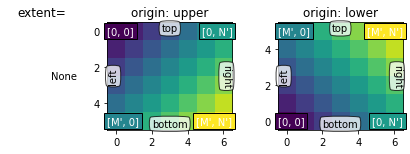

In [5]:
generate_imshow_demo_grid(extents=[None])

Generally, for an array of shape (M, N), the first index runs along the
vertical, the second index runs along the horizontal.
The pixel centers are at integer positions ranging from 0 to ``N' = N - 1``
horizontally and from 0 to ``M' = M - 1`` vertically.
*origin* determines how the data is filled in the bounding box.

For ``origin='lower'``:

   - [0, 0] is at (left, bottom)
   - [M', 0] is at (left, top)
   - [0, N'] is at (right, bottom)
   - [M', N'] is at (right, top)

``origin='upper'`` reverses the vertical axes direction and filling:

   - [0, 0] is at (left, top)
   - [M', 0] is at (left, bottom)
   - [0, N'] is at (right, top)
   - [M', N'] is at (right, bottom)

In summary, the position of the [0, 0] index as well as the extent are
influenced by *origin*:

======  ===============  ==========================================
origin  [0, 0] position  extent
======  ===============  ==========================================
upper   top left         ``(-0.5, numcols-0.5, numrows-0.5, -0.5)``
lower   bottom left      ``(-0.5, numcols-0.5, -0.5, numrows-0.5)``
======  ===============  ==========================================

The default value of *origin* is set by :rc:`image.origin` which defaults
to ``'upper'`` to match the matrix indexing conventions in math and
computer graphics image indexing conventions.


## Explicit extent

By setting *extent* we define the coordinates of the image area. The
underlying image data is interpolated/resampled to fill that area.

If the axes is set to autoscale, then the view limits of the axes are set
to match the *extent* which ensures that the coordinate set by
``(left, bottom)`` is at the bottom left of the axes!  However, this
may invert the axis so they do not increase in the 'natural' direction.




In [ ]:
extents = [(-0.5, 6.5, -0.5, 5.5),
           (-0.5, 6.5, 5.5, -0.5),
           (6.5, -0.5, -0.5, 5.5),
           (6.5, -0.5, 5.5, -0.5)]

columns = generate_imshow_demo_grid(extents)
set_extent_None_text(columns['upper'][1])
set_extent_None_text(columns['lower'][0])

## Explicit extent and axes limits

If we fix the axes limits by explicitly setting `~.axes.Axes.set_xlim` /
`~.axes.Axes.set_ylim`, we force a certain size and orientation of the axes.
This can decouple the 'left-right' and 'top-bottom' sense of the image from
the orientation on the screen.

In the example below we have chosen the limits slightly larger than the
extent (note the white areas within the Axes).

While we keep the extents as in the examples before, the coordinate (0, 0)
is now explicitly put at the bottom left and values increase to up and to
the right (from the viewer's point of view).
We can see that:

- The coordinate ``(left, bottom)`` anchors the image which then fills the
  box going towards the ``(right, top)`` point in data space.
- The first column is always closest to the 'left'.
- *origin* controls if the first row is closest to 'top' or 'bottom'.
- The image may be inverted along either direction.
- The 'left-right' and 'top-bottom' sense of the image may be uncoupled from
  the orientation on the screen.



In [ ]:
generate_imshow_demo_grid(extents=[None] + extents,
                          xlim=(-2, 8), ylim=(-1, 6))

plt.show()